In [119]:
from pgmpy.models import BayesianModel,BayesianNetwork 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, accuracy_score, mean_squared_error,precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, auc
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, ExpectationMaximization, IVEstimator
from pgmpy.inference import VariableElimination
import bnlearn as bn
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read Data

In [68]:
crash = pd.read_csv('data/crash_nyc_2021.csv').reset_index().iloc[:,1:]
crash = crash.loc[(crash['Duration (min)']>0)&(crash['Duration (min)']<=150)].reset_index()
crash['Duration_class'] = pd.cut(crash['Duration (min)'], [0,30,60,90,120,150], right=True, labels=[0,1,2,3,4])
crash = crash.dropna()
#target_var = 'Duration (min)'
target_var = 'Duration_class'

column_clear = ['Start Date Time','Direction','County', 'Year', 'TOD', 'PeakHour',
       'DayofWeek', 'MonthofYear', 'Injury involved', 'Truck involved','Lane Closure Type',
       'Fire involved', target_var]

crash['Start Date Time'] = pd.to_datetime(crash['Start Date Time'])

data = crash[crash['Start Date Time'].dt.year.isin([2021])].iloc[:,1:]

data = data[column_clear].iloc[:,1:]

In [69]:
train, test = train_test_split(data, test_size=0.25)

In [70]:
train_target = train.pop('Duration_class')

In [71]:
Xtrain, Xval, ytrain, yval = train_test_split(train, train_target, test_size=0.1, random_state=0)
valid = pd.concat([Xval, yval], axis='columns')
dfnum = pd.concat([Xtrain, ytrain], axis='columns')
dfnum

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
2174,2,0,6,1,0,1,0,0,0,1,0,0
1453,2,2,6,0,1,0,0,0,0,1,0,0
224,2,4,6,0,1,0,2,0,0,2,0,0
4137,4,3,6,0,0,0,0,1,1,2,0,1
1567,2,2,6,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5788,3,3,6,1,0,0,0,1,1,1,1,3
625,1,4,6,0,1,0,2,0,0,1,0,0
1565,2,1,6,0,0,1,0,0,0,2,0,0
3529,4,3,6,0,0,0,1,1,1,3,0,1


In [72]:
# Get mape for regression task
def get_mape(model, df, col):
    # Get accuracy score by the model for the validation dataset df with target col
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    mape = mean_absolute_percentage_error(df[col], pred)
    print('MAPE -', mape)
    return mape

In [73]:
#Get accuracy for classification task
def get_acc(model, df, col):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = accuracy_score(df[col], pred)
    print('Accuracy -', acc)
    return acc

In [74]:
def get_acc_label(model, df, col, labels):
    #pred = model.predict(df[DAG['adjmat'].columns.values].iloc[:,:-1])
    pred = model.predict(df.iloc[:,:-1])
    print(pred)
    acc = precision_recall_fscore_support(df[col], pred, average=None, labels=labels)
    print('precision, recall, f1 -', acc)
    return acc

# Bayesian Network

# Structure Learning

In [146]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='cl', root_node='Duration_class', bw_list_method='nodes', verbose=3)
#DAG = bn.structure_learning.fit(data,methodtype='cl', scoretype='bdeu')
#DAG = bn.structure_learning.fit(data,methodtype='naivebayes', scoretype='bdeu', root_node='Duration_class')


[bnlearn] >Warning: Computing DAG with 12 nodes can take a very long time!
[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/66.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


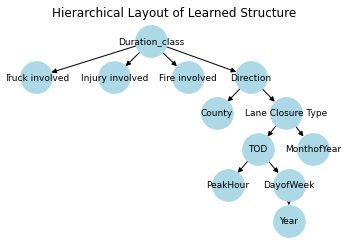

In [147]:
# Plot graph
#G = bn.plot(DAG)
# Convert Bayesian network structure to a hierarchical structure (DAG)
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Plot the hierarchical structure
plt.title('Hierarchical Layout of Learned Structure')
pos =graphviz_layout(G, prog='dot')
#fig=plt.figure(figsize=(20,10))
nx.draw(G, pos, with_labels=True, arrows=True, node_color="lightblue", node_size=1000, font_size=9)
plt.savefig('BN_structure.png')

# Parameter Learning

In [94]:
# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);
model = BayesianNetwork(ebunch=DAG['model_edges'])
bayes = BayesianEstimator(model=model, data = data)
model.fit(dfnum, estimator=BayesianEstimator, prior_type='BDeu',equivalent_sample_size=10,
          complete_samples_only=False)
model.local_independencies(bayes.variables)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Duration_class:
+-------------------+-----------+
| Duration_class(0) | 0.372563  |
+-------------------+-----------+
| Duration_class(1) | 0.289261  |
+-------------------+-----------+
| Duration_class(2) | 0.158146  |
+-------------------+-----------+
| Duration_class(3) | 0.106289  |
+-------------------+-----------+
| Duration_class(4) | 0.0737403 |
+-------------------+-----------+
[bnlearn] >CPD of Truck involved:
+-------------------+---------------------+-----+---------------------+---------------------+
| Duration_class    | Duration_class(0)   | ... | Duration_class(3)   | Duration_class(4)   |
+-------------------+---------------------+-----+---------------------+---------------------+
| Truck involved(0) | 0.9452122408687068  | ... | 0.17301038062283736 | 0.24937655

(Direction ⟂ Fire involved, Truck involved, Injury involved | Duration_class)
(County ⟂ Lane Closure Type, PeakHour, Duration_class, Fire involved, Year, Injury involved, DayofWeek, Truck involved, MonthofYear, TOD | Direction)
(Year ⟂ Lane Closure Type, PeakHour, Duration_class, Fire involved, Injury involved, Truck involved, Direction, County, MonthofYear, TOD | DayofWeek)
(TOD ⟂ Truck involved, Direction, County, Duration_class, Fire involved, MonthofYear, Injury involved | Lane Closure Type)
(PeakHour ⟂ Lane Closure Type, Duration_class, Fire involved, Year, Injury involved, DayofWeek, Truck involved, Direction, County, MonthofYear | TOD)
(DayofWeek ⟂ Lane Closure Type, PeakHour, Duration_class, Fire involved, Injury involved, Truck involved, Direction, County, MonthofYear | TOD)
(MonthofYear ⟂ PeakHour, Duration_class, Fire involved, Year, Injury involved, DayofWeek, Truck involved, Direction, County, TOD | Lane Closure Type)
(Injury involved ⟂ Lane Closure Type, PeakHour, Fire in

# Validation

In [92]:
acc1 = get_acc(model, valid, 'Duration_class')

  0%|          | 0/388 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 1
2                 3
3                 3
4                 3
..              ...
489               3
490               3
491               0
492               3
493               3

[494 rows x 1 columns]
Accuracy - 0.8643724696356275


In [912]:
acc2 = get_acc_label(model, valid, 'Duration_class', [0,1,2,3,4])

  0%|          | 0/395 [00:00<?, ?it/s]

     Duration_class
0                 1
1                 2
2                 0
3                 3
4                 0
..              ...
489               3
490               3
491               2
492               0
493               3

[494 rows x 1 columns]
precision, recall, f1 - (array([0.98342541, 0.91715976, 1.        , 0.42307692, 0.        ]), array([0.93193717, 0.99358974, 0.54054054, 1.        , 0.        ]), array([0.95698925, 0.95384615, 0.70175439, 0.59459459, 0.        ]), array([191, 156,  74,  44,  29], dtype=int64))


# Inference

In [902]:
inference = VariableElimination(model)
evidence = valid.iloc[0,:-1]
result=inference.query(variables=['Duration_class'], evidence=evidence)
print(result)

+-------------------+-----------------------+
| Duration_class    |   phi(Duration_class) |
+===================+=======================+
| Duration_class(0) |                0.0005 |
+-------------------+-----------------------+
| Duration_class(1) |                0.9931 |
+-------------------+-----------------------+
| Duration_class(2) |                0.0041 |
+-------------------+-----------------------+
| Duration_class(3) |                0.0010 |
+-------------------+-----------------------+
| Duration_class(4) |                0.0013 |
+-------------------+-----------------------+


In [936]:
valid

,Direction,County,Year,TOD,PeakHour,DayofWeek,MonthofYear,Injury involved,Truck involved,Lane Closure Type,Fire involved,Duration_class
2818,3,3,6,0,0,0,0,1,1,1,0,1
5315,2,1,6,0,0,0,2,0,1,1,1,2
280,2,1,6,0,1,0,1,0,0,2,0,0
5736,4,3,6,0,0,0,2,1,1,1,1,3
49,2,2,6,0,1,0,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5450,4,0,6,0,1,1,0,1,1,2,1,2
5832,1,2,6,0,0,1,2,1,1,1,1,3
4815,1,0,6,0,0,0,0,0,1,1,1,2
1031,3,2,6,0,1,1,0,0,0,1,0,0


# Prediction

In [913]:
result_pred = model.predict(test.iloc[:,:-1])

  0%|          | 0/991 [00:00<?, ?it/s]

In [919]:
acc_test=accuracy_score(test['Duration_class'], result_pred)
acc_label_test=precision_recall_fscore_support(test['Duration_class'], result_pred, labels=[0,1,2,3,4])
print("Test accuracy score -", acc_test)
print("Test precision, recall, F1-score and Sample Size -", acc_label_test)

Test accuracy score - 0.8807785888077859
Test precision, recall, F1-score and Sample Size - (array([0.99671593, 0.95017794, 1.        , 0.4334471 , 0.        ]), array([0.95590551, 0.99813084, 0.67164179, 1.        , 0.        ]), array([0.97588424, 0.97356427, 0.80357143, 0.6047619 , 0.        ]), array([635, 535, 268, 127,  79], dtype=int64))


In [928]:
test['Duration_class']
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3,4])
ypred = label_binarize(result_pred, classes=[0,1,2,3,4])

# AUC-ROC Curve

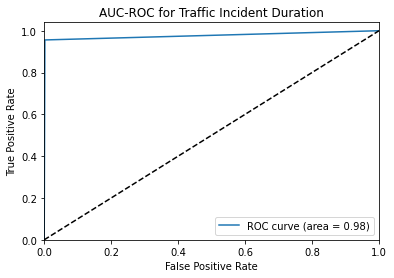

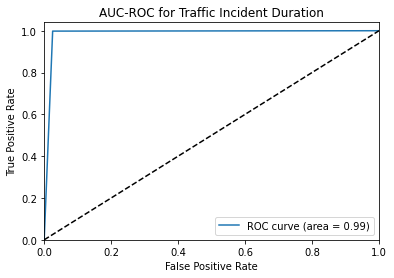

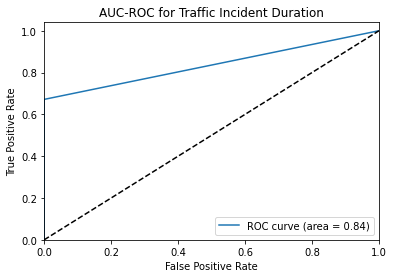

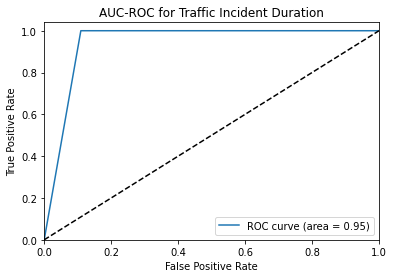

In [930]:
ytest=label_binarize(test['Duration_class'], classes=[0,1,2,3,4])
fpr, tpr = dict(), dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ytest[:,i], ypred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.04])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for Traffic Incident Duration')
    plt.legend(loc='lower right')
    plt.show()

In [148]:
# Fitting Classifier to the Training Set
model = DecisionTreeClassifier(criterion='entropy',max_depth=2, random_state=42)
model.fit(Xtrain, ytrain)

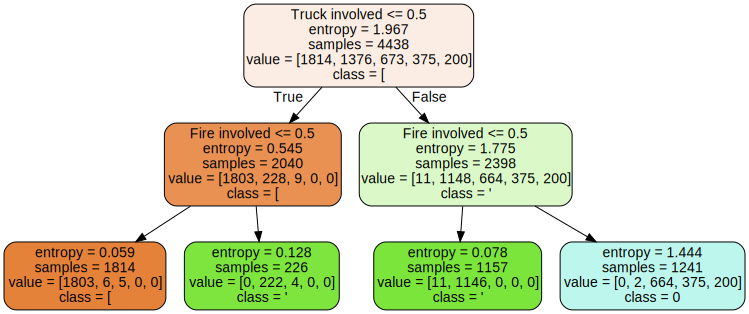

In [66]:
# Visualize the tree by graphiz
import graphviz
from sklearn import tree
feature_names = dfnum.columns[:-1]
class_names=['0','1','2','3','4']
dot_data = tree.export_graphviz(model, out_file=None, filled=True, rounded = True, feature_names=feature_names, class_names=str(class_names))
graph = graphviz.Source(dot_data)
graph